In [1]:
import matplotlib.pyplot as plt
import re
import pandas as pd
import os
import numpy as np

In [2]:
import seaborn as sns

In [3]:
%matplotlib widget

In [51]:
valid_loss = 'lm-loss-validation/VALID_{}/lm loss validation'
all_sources = "all_sources_weighted"

# Load results

In [4]:
he_results = pd.read_csv("/home/toolkit/code/bigcode-notebooks/data/arjun_results/pass_k.csv")

Parse model size and compute

In [5]:
he_results

,Experiment,k,PassRate
0,humaneval-js-bigcode_scalinglaws_run_111.5M_1e...,10,0.03
1,humaneval-js-bigcode_scalinglaws_run_111.5M_1e...,100,0.06
2,humaneval-js-bigcode_scalinglaws_run_111.5M_3e...,10,0.03
3,humaneval-js-bigcode_scalinglaws_run_111.5M_3e...,100,0.07
4,humaneval-js-bigcode_scalinglaws_run_111.5M_6e...,10,0.02
...,...,...,...
395,humaneval-py-bigcode_scalinglaws_run_15.9M_3e+...,100,0.00
396,humaneval-py-bigcode_scalinglaws_run_74.7M_3e+...,10,0.01
397,humaneval-py-bigcode_scalinglaws_run_74.7M_3e+...,100,0.03
398,humaneval-rb-bigcode_scalinglaws_run_159.5M_6e...,10,0.00


In [8]:
exp_name_pattern = r'humaneval-([^-]+)-bigcode_scalinglaws_(run_([\d\.]+)M_([^_]+)_[^-]+)-([\d\.]+)'
def parse_exp_name(exp_name):
    match = re.match(exp_name_pattern, exp_name)
    assert match is not None
    lang, run_name, model_size, compute, temperature =  match.groups()
    return lang, run_name, float(model_size), float(compute), float(temperature)

In [33]:
he_results['benchmark_lang'], he_results['name'], he_results['model_size'], he_results['compute'], he_results['temperature'] = zip(*he_results['Experiment'].map(parse_exp_name))

In [10]:
he_results

,Experiment,k,PassRate,benchmark_lang,run_name,model_size,compute,temperature
0,humaneval-js-bigcode_scalinglaws_run_111.5M_1e...,10,0.03,js,run_111.5M_1e+19_bs32_idx_30,111.5,1.000000e+19,0.8
1,humaneval-js-bigcode_scalinglaws_run_111.5M_1e...,100,0.06,js,run_111.5M_1e+19_bs32_idx_30,111.5,1.000000e+19,0.8
2,humaneval-js-bigcode_scalinglaws_run_111.5M_3e...,10,0.03,js,run_111.5M_3e+19_bs32_idx_43,111.5,3.000000e+19,0.8
3,humaneval-js-bigcode_scalinglaws_run_111.5M_3e...,100,0.07,js,run_111.5M_3e+19_bs32_idx_43,111.5,3.000000e+19,0.8
4,humaneval-js-bigcode_scalinglaws_run_111.5M_6e...,10,0.02,js,run_111.5M_6e+18_bs32_idx_17,111.5,6.000000e+18,0.8
...,...,...,...,...,...,...,...,...
395,humaneval-py-bigcode_scalinglaws_run_15.9M_3e+...,100,0.00,py,run_15.9M_3e+18_bs64_idx_2,15.9,3.000000e+18,0.8
396,humaneval-py-bigcode_scalinglaws_run_74.7M_3e+...,10,0.01,py,run_74.7M_3e+18_bs32_idx_5,74.7,3.000000e+18,0.8
397,humaneval-py-bigcode_scalinglaws_run_74.7M_3e+...,100,0.03,py,run_74.7M_3e+18_bs32_idx_5,74.7,3.000000e+18,0.8
398,humaneval-rb-bigcode_scalinglaws_run_159.5M_6e...,10,0.00,rb,run_159.5M_6e+19_bs32_idx_58,159.5,6.000000e+19,0.8


In [66]:
benchmark_langs = list(he_results["benchmark_lang"].unique())
ks = list(he_results["k"].unique())
benchmark_langs, ks

(['js', 'rb', 'py'], [10, 100])

In [11]:
python_results = he_results[(he_results["benchmark_lang"]=="py") & (he_results['k'] == 100)]

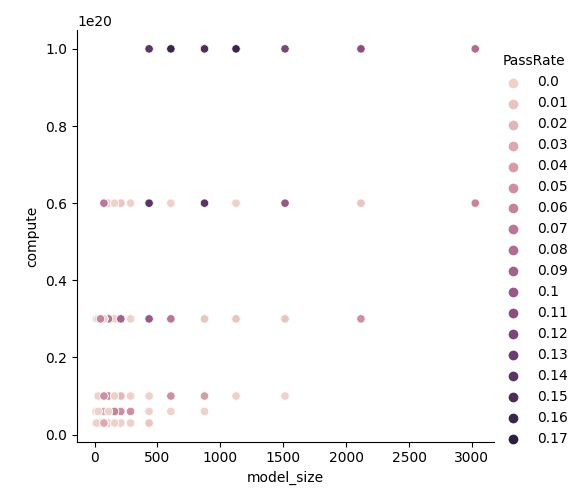

In [13]:
g = sns.relplot(data=he_results, x='model_size', y='compute',
                hue='PassRate', legend='full'
               )

# Get metrics from WandB (valid loss)

In [15]:
import wandb

api = wandb.Api()
entity, project = "loubnabnl", "scaling_laws"  # set to your entity and project 
runs = api.runs(entity + "/" + project) 

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
         if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

orig_runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

In [127]:
# The summary takes the last value for each metric
orig_runs_df

,summary,config,name
0,"{'lm loss': 2.445237159729004, 'samples': 4556...","{'lr': 0.0001, 'bf16': True, 'fp16': False, 'l...",run_5360.3M_1e+21_bs8_idx_114-nomqa
1,"{'samples': 2529280, 'grad-norm': 0.8699562617...","{'lr': 0.00016, 'bf16': True, 'fp16': False, '...",4.3b_gpt3_nemo_32_more_warmp
2,"{'lm loss': 2.027397632598877, '_runtime': 658...","{'lr': 0.00016, 'bf16': True, 'fp16': False, '...",5b_gpt3_nemo_32
3,"{'learning-rate': 4.998904542123272e-05, 'tflo...","{'lr': 5e-05, 'bf16': True, 'fp16': False, 'lo...",run_5360.3M_1e+21_bs8_idx_114-init-low-lr
4,"{'lm loss': 4.807007789611816, 'grad-norm': 44...","{'lr': 0.00016, 'bf16': True, 'fp16': False, '...",5b_gpt3_nemo_32
...,...,...,...
329,{'_wandb': {'runtime': 18}},"{'lr': 0.0003, 'bf16': True, 'fp16': False, 'l...",model_id5
330,"{'samples': 1254400, 'grad-norm': 8.9077224317...","{'lr': 0.0003, 'bf16': True, 'fp16': False, 'l...",model_id2
331,"{'lm loss': 3.056739330291748, 'samples': 1423...","{'lr': 0.0003, 'bf16': True, 'fp16': False, 'l...",model_id1
332,{},"{'lr': 0.0003, 'bf16': True, 'fp16': False, 'l...",twilight-paper-2


In [44]:
def expand_dict_to_columns(df, col):
    return pd.concat([df.drop([col], axis=1),  pd.json_normalize(df[col])], axis=1)

run_df = expand_dict_to_columns(orig_runs_df, "summary")
run_df = expand_dict_to_columns(run_df, "config")

In [45]:
# Remove useless columns
keep_cols = [c for c in run_df if "lm-loss-validation/TEST_" not in c]
run_df = run_df[keep_cols]

In [46]:
# Remove runs that didn't finish
# TODO: somehow one run's last step is not exactly equal to train-iter. And the reported validation is not for the final step. 
# run-name: run_209.0M_3e+19_bs32_idx_45
# run_df = run_df[run_df["_step"] == run_df["train_iters"]]
run_df = run_df[run_df["_step"] >= .99 * run_df["train_iters"]]

In [47]:
for run_name in he_results["name"]:
    assert run_name in list(run_df["name"]), run_name

In [49]:
exp_df = he_results.merge(run_df, on="name")

In [50]:
exp_df

,Experiment,k,PassRate,benchmark_lang,run_name,model_size,compute,temperature,name,lm loss,...,scatter_gather_tensors_in_pipeline,use_checkpoint_opt_param_scheduler,use_contiguous_buffers_in_local_ddp,biencoder_shared_query_context_model,virtual_pipeline_model_parallel_size,async_tensor_model_parallel_allreduce,num_layers_per_virtual_pipeline_stage,inference_batch_times_seqlen_threshold,apply_residual_connection_post_layernorm,transformer_pipeline_model_parallel_size
0,humaneval-js-bigcode_scalinglaws_run_111.5M_1e...,10,0.03,js,run_111.5M_1e+19_bs32_idx_30,111.5,1.000000e+19,0.8,run_111.5M_1e+19_bs32_idx_30,1.42353,...,True,False,True,False,None,True,None,512,False,1
1,humaneval-js-bigcode_scalinglaws_run_111.5M_1e...,100,0.06,js,run_111.5M_1e+19_bs32_idx_30,111.5,1.000000e+19,0.8,run_111.5M_1e+19_bs32_idx_30,1.42353,...,True,False,True,False,None,True,None,512,False,1
2,humaneval-rb-bigcode_scalinglaws_run_111.5M_1e...,10,0.00,rb,run_111.5M_1e+19_bs32_idx_30,111.5,1.000000e+19,0.8,run_111.5M_1e+19_bs32_idx_30,1.42353,...,True,False,True,False,None,True,None,512,False,1
3,humaneval-rb-bigcode_scalinglaws_run_111.5M_1e...,100,0.00,rb,run_111.5M_1e+19_bs32_idx_30,111.5,1.000000e+19,0.8,run_111.5M_1e+19_bs32_idx_30,1.42353,...,True,False,True,False,None,True,None,512,False,1
4,humaneval-py-bigcode_scalinglaws_run_111.5M_1e...,10,0.02,py,run_111.5M_1e+19_bs32_idx_30,111.5,1.000000e+19,0.8,run_111.5M_1e+19_bs32_idx_30,1.42353,...,True,False,True,False,None,True,None,512,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,humaneval-js-bigcode_scalinglaws_run_874.2M_3e...,100,0.08,js,run_874.2M_3e+19_bs16_idx_49,874.2,3.000000e+19,0.8,run_874.2M_3e+19_bs16_idx_49,1.329674,...,True,False,True,False,None,True,None,512,False,1
396,humaneval-py-bigcode_scalinglaws_run_874.2M_3e...,10,0.04,py,run_874.2M_3e+19_bs16_idx_49,874.2,3.000000e+19,0.8,run_874.2M_3e+19_bs16_idx_49,1.329674,...,True,False,True,False,None,True,None,512,False,1
397,humaneval-py-bigcode_scalinglaws_run_874.2M_3e...,100,0.08,py,run_874.2M_3e+19_bs16_idx_49,874.2,3.000000e+19,0.8,run_874.2M_3e+19_bs16_idx_49,1.329674,...,True,False,True,False,None,True,None,512,False,1
398,humaneval-rb-bigcode_scalinglaws_run_874.2M_3e...,10,0.01,rb,run_874.2M_3e+19_bs16_idx_49,874.2,3.000000e+19,0.8,run_874.2M_3e+19_bs16_idx_49,1.329674,...,True,False,True,False,None,True,None,512,False,1


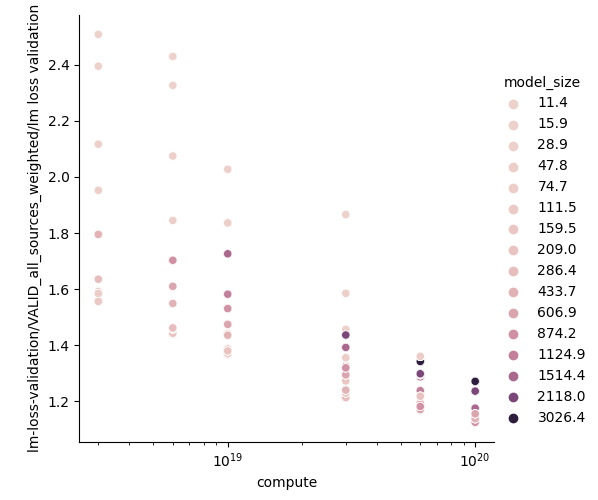

In [126]:
g = sns.relplot(data=exp_df, x='compute', y=valid_loss.format(all_sources),
                hue='model_size', legend='full'
               )
g.set(xscale="log")

## Pairwise loss correlation

In [60]:
# Do not plot all sources at one on the pairwise correlation plot.
# Crashes if there are too many of those.
plot_sources = [all_sources, "python", "javascript"]

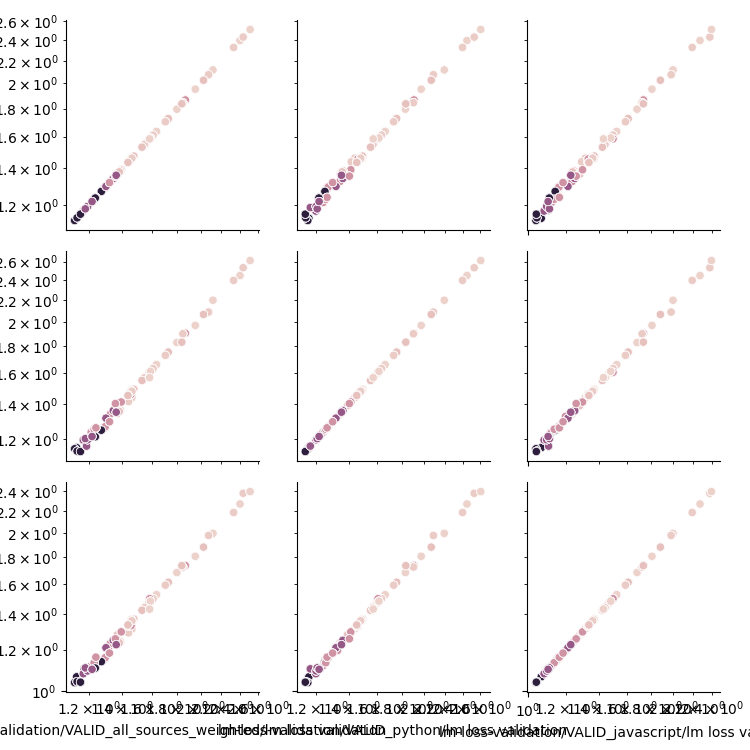

In [59]:
g = sns.PairGrid(exp_df[[valid_loss.format(source) for source in plot_sources] + ["compute"]], hue="compute")
g.set(xscale="log")
g.set(yscale="log")
g.map(sns.scatterplot)

## Loss - HE performance correlation

In [69]:
per_benchmark_df = {
    (lang, k): exp_df[(exp_df["benchmark_lang"] == lang) & (exp_df["k"] == k)]
    for lang in benchmark_langs
    for k in ks
}

In [106]:
lang_to_he_benchmark = {
    "python": "py",
    "javascript": "js",
    "ruby": "rb"
}

def plot_loss_he_correlation(lang, k):
    g = sns.relplot(data=per_benchmark_df[(lang_to_he_benchmark.get(lang, lang), k)], x=valid_loss.format(lang), y='PassRate',
                    hue='compute', legend='full'
                   )
    # g.set(xscale="log")
    g.set_xlabels(f"{lang} validation loss")
    g.set_ylabels(f"{lang} pass@100")

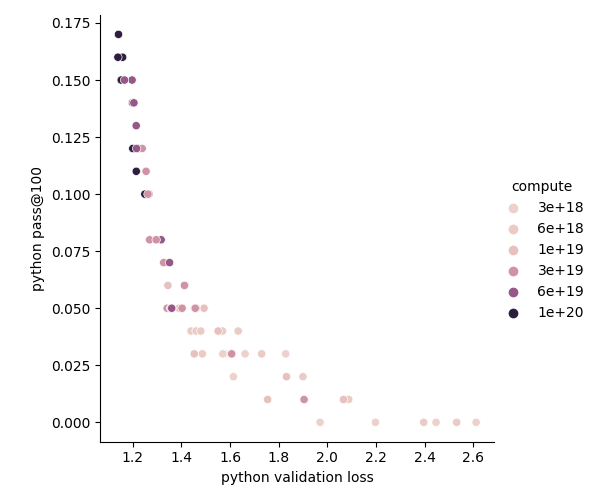

In [107]:
plot_loss_he_correlation("python", 100)

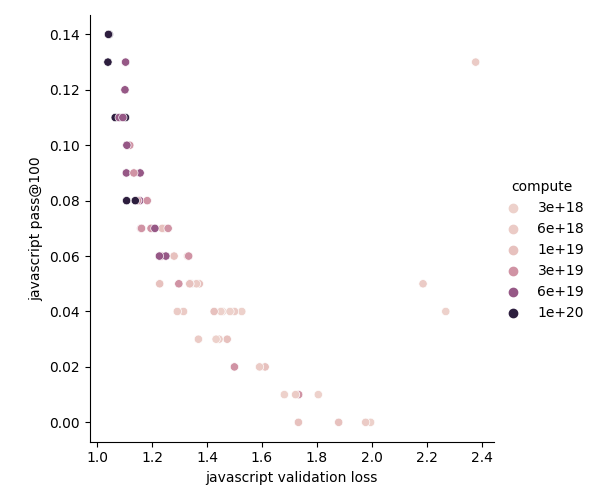

In [108]:
plot_loss_he_correlation("javascript", 100)

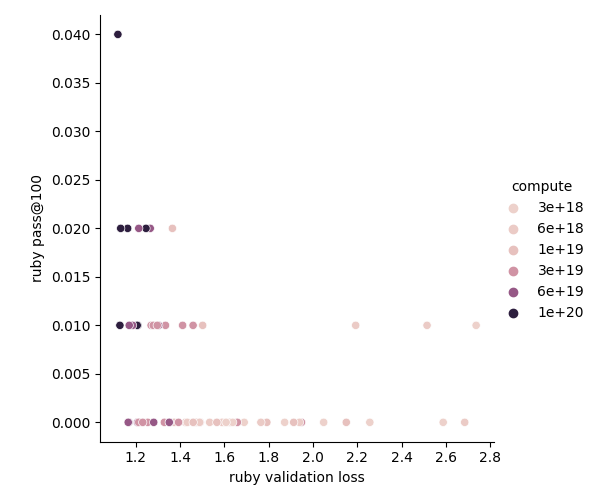

In [109]:
plot_loss_he_correlation("ruby", 100)

# Optimal runs

In [118]:
def get_optimal_rows(df, groupby="compute", target='PassRate'):
    if target == 'PassRate':
        transform = max
    elif "loss" in target:
        transform = min
    else:
        raise ValueError("Could not infer whether target was lower-is-better or higher-is-better")
    idx = df.groupby([groupby])[target].transform(transform) == df[target]
    return df[idx]

## How to get the best validation loss given a compute

In [119]:
get_optimal_rows(per_benchmark_df[("py", 100)], target=valid_loss.format("python"))

,Experiment,k,PassRate,benchmark_lang,run_name,model_size,compute,temperature,name,lm loss,...,scatter_gather_tensors_in_pipeline,use_checkpoint_opt_param_scheduler,use_contiguous_buffers_in_local_ddp,biencoder_shared_query_context_model,virtual_pipeline_model_parallel_size,async_tensor_model_parallel_allreduce,num_layers_per_virtual_pipeline_stage,inference_batch_times_seqlen_threshold,apply_residual_connection_post_layernorm,transformer_pipeline_model_parallel_size
45,humaneval-py-bigcode_scalinglaws_run_159.5M_1e...,100,0.06,py,run_159.5M_1e+19_bs32_idx_31,159.5,1.000000e+19,0.8,run_159.5M_1e+19_bs32_idx_31,1.43136,...,True,False,True,False,None,True,None,512,False,1
59,humaneval-py-bigcode_scalinglaws_run_159.5M_6e...,100,0.06,py,run_159.5M_6e+18_bs32_idx_18,159.5,6.000000e+18,0.8,run_159.5M_6e+18_bs32_idx_18,1.442635,...,True,False,True,False,None,True,None,512,False,1
121,humaneval-py-bigcode_scalinglaws_run_286.4M_3e...,100,0.12,py,run_286.4M_3e+19_bs16_idx_46,286.4,3.000000e+19,0.8,run_286.4M_3e+19_bs16_idx_46,1.276311,...,True,False,True,False,None,True,None,512,False,1
215,humaneval-py-bigcode_scalinglaws_run_606.9M_1e...,100,0.16,py,run_606.9M_1e+20_bs16_idx_77,606.9,1.000000e+20,0.8,run_606.9M_1e+20_bs16_idx_77,1.196672,...,True,False,True,False,None,True,None,512,False,1
335,humaneval-py-bigcode_scalinglaws_run_286.4M_6e...,100,0.15,py,run_286.4M_6e+19_bs16_idx_60,286.4,6.000000e+19,0.8,run_286.4M_6e+19_bs16_idx_60,1.218039,...,True,False,True,False,None,True,None,512,False,1
381,humaneval-py-bigcode_scalinglaws_run_74.7M_3e+...,100,0.03,py,run_74.7M_3e+18_bs32_idx_5,74.7,3.000000e+18,0.8,run_74.7M_3e+18_bs32_idx_5,1.644637,...,True,False,True,False,None,True,None,512,False,1


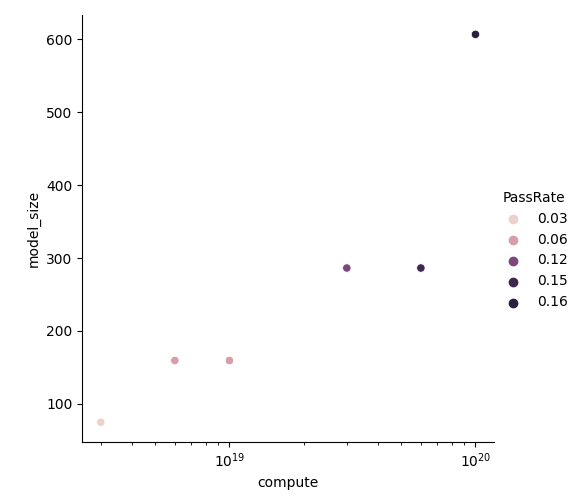

In [121]:
g = sns.relplot(
    data=get_optimal_rows(
        per_benchmark_df[("py", 100)],
        target=valid_loss.format("python")
    ),
    x='compute', y='model_size',
    hue='PassRate', legend='full', 
)
g.set(xscale="log")

## How to get the best HE performance given a compute

In [76]:
get_optimal_rows(per_benchmark_df[("py", 100)])

,Experiment,k,PassRate,benchmark_lang,run_name,model_size,compute,temperature,name,lm loss,...,scatter_gather_tensors_in_pipeline,use_checkpoint_opt_param_scheduler,use_contiguous_buffers_in_local_ddp,biencoder_shared_query_context_model,virtual_pipeline_model_parallel_size,async_tensor_model_parallel_allreduce,num_layers_per_virtual_pipeline_stage,inference_batch_times_seqlen_threshold,apply_residual_connection_post_layernorm,transformer_pipeline_model_parallel_size
27,humaneval-py-bigcode_scalinglaws_run_111.5M_3e...,100,0.03,py,run_111.5M_3e+18_bs32_idx_6,111.5,3.000000e+18,0.8,run_111.5M_3e+18_bs32_idx_6,1.564602,...,True,False,True,False,None,True,None,512,False,1
33,humaneval-py-bigcode_scalinglaws_run_159.5M_3e...,100,0.03,py,run_159.5M_3e+18_bs32_idx_7,159.5,3.000000e+18,0.8,run_159.5M_3e+18_bs32_idx_7,1.6292,...,True,False,True,False,None,True,None,512,False,1
45,humaneval-py-bigcode_scalinglaws_run_159.5M_1e...,100,0.06,py,run_159.5M_1e+19_bs32_idx_31,159.5,1.000000e+19,0.8,run_159.5M_1e+19_bs32_idx_31,1.43136,...,True,False,True,False,None,True,None,512,False,1
59,humaneval-py-bigcode_scalinglaws_run_159.5M_6e...,100,0.06,py,run_159.5M_6e+18_bs32_idx_18,159.5,6.000000e+18,0.8,run_159.5M_6e+18_bs32_idx_18,1.442635,...,True,False,True,False,None,True,None,512,False,1
121,humaneval-py-bigcode_scalinglaws_run_286.4M_3e...,100,0.12,py,run_286.4M_3e+19_bs16_idx_46,286.4,3.000000e+19,0.8,run_286.4M_3e+19_bs16_idx_46,1.276311,...,True,False,True,False,None,True,None,512,False,1
159,humaneval-py-bigcode_scalinglaws_run_433.7M_1e...,100,0.17,py,run_433.7M_1e+20_bs16_idx_76,433.7,1.000000e+20,0.8,run_433.7M_1e+20_bs16_idx_76,1.286342,...,True,False,True,False,None,True,None,512,False,1
163,humaneval-py-bigcode_scalinglaws_run_433.7M_3e...,100,0.03,py,run_433.7M_3e+18_bs16_idx_10,433.7,3.000000e+18,0.8,run_433.7M_3e+18_bs16_idx_10,1.822244,...,True,False,True,False,None,True,None,512,False,1
171,humaneval-py-bigcode_scalinglaws_run_286.4M_3e...,100,0.03,py,run_286.4M_3e+18_bs16_idx_9,286.4,3.000000e+18,0.8,run_286.4M_3e+18_bs16_idx_9,1.751944,...,True,False,True,False,None,True,None,512,False,1
199,humaneval-py-bigcode_scalinglaws_run_606.9M_6e...,100,0.15,py,run_606.9M_6e+19_bs16_idx_62,606.9,6.000000e+19,0.8,run_606.9M_6e+19_bs16_idx_62,1.186096,...,True,False,True,False,None,True,None,512,False,1
335,humaneval-py-bigcode_scalinglaws_run_286.4M_6e...,100,0.15,py,run_286.4M_6e+19_bs16_idx_60,286.4,6.000000e+19,0.8,run_286.4M_6e+19_bs16_idx_60,1.218039,...,True,False,True,False,None,True,None,512,False,1


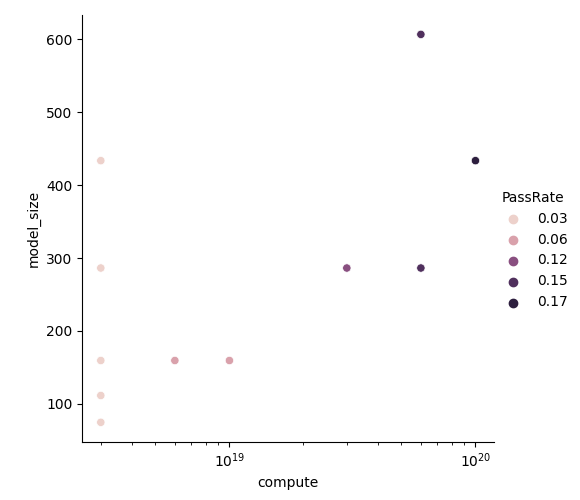

In [110]:
# Optimal run, per compute-budget
g = sns.relplot(data=get_optimal_rows(per_benchmark_df[("py", 100)]), x='compute', y='model_size',
                hue='PassRate', legend='full', 
               )
g.set(xscale="log")

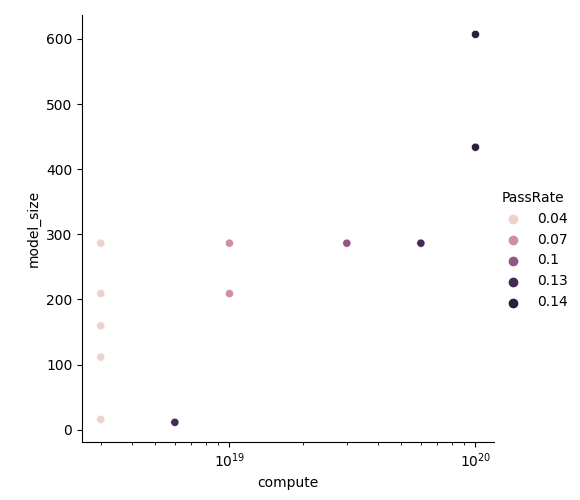

In [111]:
# Optimal run, per compute-budget
g = sns.relplot(data=get_optimal_rows(per_benchmark_df[("js", 100)]), x='compute', y='model_size',
                hue='PassRate', legend='full', 
               )
g.set(xscale="log")

In [72]:
exp_df[idx]

,Experiment,k,PassRate,benchmark_lang,run_name,model_size,compute,temperature,name,lm loss,...,scatter_gather_tensors_in_pipeline,use_checkpoint_opt_param_scheduler,use_contiguous_buffers_in_local_ddp,biencoder_shared_query_context_model,virtual_pipeline_model_parallel_size,async_tensor_model_parallel_allreduce,num_layers_per_virtual_pipeline_stage,inference_batch_times_seqlen_threshold,apply_residual_connection_post_layernorm,transformer_pipeline_model_parallel_size
25,humaneval-js-bigcode_scalinglaws_run_111.5M_3e...,100,0.04,js,run_111.5M_3e+18_bs32_idx_6,111.5,3.000000e+18,0.8,run_111.5M_3e+18_bs32_idx_6,1.564602,...,True,False,True,False,None,True,None,512,False,1
31,humaneval-js-bigcode_scalinglaws_run_159.5M_3e...,100,0.04,js,run_159.5M_3e+18_bs32_idx_7,159.5,3.000000e+18,0.8,run_159.5M_3e+18_bs32_idx_7,1.6292,...,True,False,True,False,None,True,None,512,False,1
79,humaneval-js-bigcode_scalinglaws_run_15.9M_3e+...,100,0.04,js,run_15.9M_3e+18_bs64_idx_2,15.9,3.000000e+18,0.8,run_15.9M_3e+18_bs64_idx_2,2.486125,...,True,False,True,False,None,True,None,512,False,1
103,humaneval-js-bigcode_scalinglaws_run_11.4M_6e+...,100,0.13,js,run_11.4M_6e+18_bs64_idx_12,11.4,6.000000e+18,0.8,run_11.4M_6e+18_bs64_idx_12,2.675163,...,True,False,True,False,None,True,None,512,False,1
121,humaneval-py-bigcode_scalinglaws_run_286.4M_3e...,100,0.12,py,run_286.4M_3e+19_bs16_idx_46,286.4,3.000000e+19,0.8,run_286.4M_3e+19_bs16_idx_46,1.276311,...,True,False,True,False,None,True,None,512,False,1
159,humaneval-py-bigcode_scalinglaws_run_433.7M_1e...,100,0.17,py,run_433.7M_1e+20_bs16_idx_76,433.7,1.000000e+20,0.8,run_433.7M_1e+20_bs16_idx_76,1.286342,...,True,False,True,False,None,True,None,512,False,1
169,humaneval-js-bigcode_scalinglaws_run_286.4M_3e...,100,0.04,js,run_286.4M_3e+18_bs16_idx_9,286.4,3.000000e+18,0.8,run_286.4M_3e+18_bs16_idx_9,1.751944,...,True,False,True,False,None,True,None,512,False,1
175,humaneval-js-bigcode_scalinglaws_run_286.4M_1e...,100,0.07,js,run_286.4M_1e+19_bs16_idx_33,286.4,1.000000e+19,0.8,run_286.4M_1e+19_bs16_idx_33,1.432813,...,True,False,True,False,None,True,None,512,False,1
181,humaneval-js-bigcode_scalinglaws_run_209.0M_1e...,100,0.07,js,run_209.0M_1e+19_bs32_idx_32,209.0,1.000000e+19,0.8,run_209.0M_1e+19_bs32_idx_32,1.440455,...,True,False,True,False,None,True,None,512,False,1
199,humaneval-py-bigcode_scalinglaws_run_606.9M_6e...,100,0.15,py,run_606.9M_6e+19_bs16_idx_62,606.9,6.000000e+19,0.8,run_606.9M_6e+19_bs16_idx_62,1.186096,...,True,False,True,False,None,True,None,512,False,1


In [62]:
exp_df.groupby("compute").max()

,Experiment,k,PassRate,benchmark_lang,run_name,model_size,temperature,name,lm loss,samples,...,scatter_gather_tensors_in_pipeline,use_checkpoint_opt_param_scheduler,use_contiguous_buffers_in_local_ddp,biencoder_shared_query_context_model,virtual_pipeline_model_parallel_size,async_tensor_model_parallel_allreduce,num_layers_per_virtual_pipeline_stage,inference_batch_times_seqlen_threshold,apply_residual_connection_post_layernorm,transformer_pipeline_model_parallel_size
compute,,,,,,,,,,,,,,,,,,,,,
3.000000e+18,humaneval-rb-bigcode_scalinglaws_run_74.7M_3e+...,100,0.04,rb,run_74.7M_3e+18_bs32_idx_5,433.7,0.8,run_74.7M_3e+18_bs32_idx_5,2.675353,21345280.0,...,True,False,True,False,NaN,True,NaN,512,False,1
6.000000e+18,humaneval-rb-bigcode_scalinglaws_run_874.2M_6e...,100,0.13,rb,run_874.2M_6e+18_bs16_idx_23,874.2,0.8,run_874.2M_6e+18_bs16_idx_23,2.675163,42693120.0,...,True,False,True,False,NaN,True,NaN,512,False,1
1.000000e+19,humaneval-rb-bigcode_scalinglaws_run_874.2M_1e...,100,0.07,rb,run_874.2M_1e+19_bs16_idx_36,1514.4,0.8,run_874.2M_1e+19_bs16_idx_36,2.224324,28177920.0,...,True,False,True,False,NaN,True,NaN,512,False,1
3.000000e+19,humaneval-rb-bigcode_scalinglaws_run_874.2M_3e...,100,0.12,rb,run_874.2M_3e+19_bs16_idx_49,2118.0,0.8,run_874.2M_3e+19_bs16_idx_49,1.929592,153505280.0,...,True,False,True,False,NaN,True,NaN,512,False,1
6.000000e+19,humaneval-rb-bigcode_scalinglaws_run_874.2M_6e...,100,0.15,rb,run_874.2M_6e+19_bs16_idx_63,3026.4,0.8,run_874.2M_6e+19_bs16_idx_63,1.425249,65364480.0,...,True,False,True,False,NaN,True,NaN,512,False,1
1.000000e+20,humaneval-rb-bigcode_scalinglaws_run_874.2M_1e...,100,0.17,rb,run_874.2M_1e+20_bs16_idx_78,3026.4,0.8,run_874.2M_1e+20_bs16_idx_78,1.286342,18764800.0,...,True,False,True,False,NaN,True,NaN,512,False,1


In [61]:
exp_df

,Experiment,k,PassRate,benchmark_lang,run_name,model_size,compute,temperature,name,lm loss,...,scatter_gather_tensors_in_pipeline,use_checkpoint_opt_param_scheduler,use_contiguous_buffers_in_local_ddp,biencoder_shared_query_context_model,virtual_pipeline_model_parallel_size,async_tensor_model_parallel_allreduce,num_layers_per_virtual_pipeline_stage,inference_batch_times_seqlen_threshold,apply_residual_connection_post_layernorm,transformer_pipeline_model_parallel_size
0,humaneval-js-bigcode_scalinglaws_run_111.5M_1e...,10,0.03,js,run_111.5M_1e+19_bs32_idx_30,111.5,1.000000e+19,0.8,run_111.5M_1e+19_bs32_idx_30,1.42353,...,True,False,True,False,None,True,None,512,False,1
1,humaneval-js-bigcode_scalinglaws_run_111.5M_1e...,100,0.06,js,run_111.5M_1e+19_bs32_idx_30,111.5,1.000000e+19,0.8,run_111.5M_1e+19_bs32_idx_30,1.42353,...,True,False,True,False,None,True,None,512,False,1
2,humaneval-rb-bigcode_scalinglaws_run_111.5M_1e...,10,0.00,rb,run_111.5M_1e+19_bs32_idx_30,111.5,1.000000e+19,0.8,run_111.5M_1e+19_bs32_idx_30,1.42353,...,True,False,True,False,None,True,None,512,False,1
3,humaneval-rb-bigcode_scalinglaws_run_111.5M_1e...,100,0.00,rb,run_111.5M_1e+19_bs32_idx_30,111.5,1.000000e+19,0.8,run_111.5M_1e+19_bs32_idx_30,1.42353,...,True,False,True,False,None,True,None,512,False,1
4,humaneval-py-bigcode_scalinglaws_run_111.5M_1e...,10,0.02,py,run_111.5M_1e+19_bs32_idx_30,111.5,1.000000e+19,0.8,run_111.5M_1e+19_bs32_idx_30,1.42353,...,True,False,True,False,None,True,None,512,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,humaneval-js-bigcode_scalinglaws_run_874.2M_3e...,100,0.08,js,run_874.2M_3e+19_bs16_idx_49,874.2,3.000000e+19,0.8,run_874.2M_3e+19_bs16_idx_49,1.329674,...,True,False,True,False,None,True,None,512,False,1
396,humaneval-py-bigcode_scalinglaws_run_874.2M_3e...,10,0.04,py,run_874.2M_3e+19_bs16_idx_49,874.2,3.000000e+19,0.8,run_874.2M_3e+19_bs16_idx_49,1.329674,...,True,False,True,False,None,True,None,512,False,1
397,humaneval-py-bigcode_scalinglaws_run_874.2M_3e...,100,0.08,py,run_874.2M_3e+19_bs16_idx_49,874.2,3.000000e+19,0.8,run_874.2M_3e+19_bs16_idx_49,1.329674,...,True,False,True,False,None,True,None,512,False,1
398,humaneval-rb-bigcode_scalinglaws_run_874.2M_3e...,10,0.01,rb,run_874.2M_3e+19_bs16_idx_49,874.2,3.000000e+19,0.8,run_874.2M_3e+19_bs16_idx_49,1.329674,...,True,False,True,False,None,True,None,512,False,1
